# Intro

In [1]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import models
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score, fbeta_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBClassifier

In [2]:
RANDOM_SEED = 100531899

In [3]:
METADATA_COL2DESC = {
    "isic_id": "Unique identifier for each image case.",
    "target": "Binary class label (0 = benign, 1 = malignant).",
    "patient_id": "Unique identifier for each patient.",
    "age_approx": "Approximate age of the patient at time of imaging.",
    "sex": "Sex of the patient (male or female).",
    "anatom_site_general": "General location of the lesion on the patient's body.",
    "clin_size_long_diam_mm": "Maximum diameter of the lesion (mm).",
    "image_type": "Type of image captured, as defined in the ISIC Archive.",
    "tbp_tile_type": "Lighting modality of the 3D Total Body Photography (TBP) source image.",
    "tbp_lv_A": "Color channel A (green-red axis in LAB space) inside the lesion.",
    "tbp_lv_Aext": "Color channel A outside the lesion.",
    "tbp_lv_B": "Color channel B (blue-yellow axis in LAB space) inside the lesion.",
    "tbp_lv_Bext": "Color channel B outside the lesion.",
    "tbp_lv_C": "Chroma value inside the lesion.",
    "tbp_lv_Cext": "Chroma value outside the lesion.",
    "tbp_lv_H": "Hue value inside the lesion (LAB color space).",
    "tbp_lv_Hext": "Hue value outside the lesion.",
    "tbp_lv_L": "Luminance inside the lesion (LAB color space).",
    "tbp_lv_Lext": "Luminance outside the lesion.",
    "tbp_lv_areaMM2": "Area of the lesion in mm².",
    "tbp_lv_area_perim_ratio": "Ratio of the lesion's perimeter to its area (border jaggedness).",
    "tbp_lv_color_std_mean": "Mean color irregularity within the lesion.",
    "tbp_lv_deltaA": "Average contrast in color channel A between inside and outside.",
    "tbp_lv_deltaB": "Average contrast in color channel B between inside and outside.",
    "tbp_lv_deltaL": "Average contrast in luminance between inside and outside.",
    "tbp_lv_deltaLB": "Combined contrast between the lesion and surrounding skin.",
    "tbp_lv_deltaLBnorm": "Normalized contrast (LAB color space).",
    "tbp_lv_eccentricity": "Eccentricity of the lesion (how elongated it is).",
    "tbp_lv_location": "Detailed anatomical location (e.g., Upper Arm).",
    "tbp_lv_location_simple": "Simplified anatomical location (e.g., Arm).",
    "tbp_lv_minorAxisMM": "Smallest diameter of the lesion in mm.",
    "tbp_lv_nevi_confidence": "Confidence score (0-100) for the lesion being a nevus.",
    "tbp_lv_norm_border": "Normalized border irregularity (0-10 scale).",
    "tbp_lv_norm_color": "Normalized color variation (0-10 scale).",
    "tbp_lv_perimeterMM": "Perimeter of the lesion in mm.",
    "tbp_lv_radial_color_std_max": "Color asymmetry within the lesion, measured radially.",
    "tbp_lv_stdL": "Std. deviation of luminance inside the lesion.",
    "tbp_lv_stdLExt": "Std. deviation of luminance outside the lesion.",
    "tbp_lv_symm_2axis": "Asymmetry about a second axis of symmetry.",
    "tbp_lv_symm_2axis_angle": "Angle of that second axis of symmetry.",
    "tbp_lv_x": "X-coordinate in the 3D TBP model.",
    "tbp_lv_y": "Y-coordinate in the 3D TBP model.",
    "tbp_lv_z": "Z-coordinate in the 3D TBP model.",
    "attribution": "Image source or institution.",
    "copyright_license": "License information.",
    "lesion_id": "Unique ID for lesions of interest.",
    "iddx_full": "Full diagnosis classification.",
    "iddx_1": "First-level (broad) diagnosis.",
    "iddx_2": "Second-level diagnosis.",
    "iddx_3": "Third-level diagnosis.",
    "iddx_4": "Fourth-level diagnosis.",
    "iddx_5": "Fifth-level diagnosis.",
    "mel_mitotic_index": "Mitotic index of invasive malignant melanomas.",
    "mel_thick_mm": "Thickness of melanoma invasion in mm.",
    "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100) from a DNN classifier."
}

METADATA_COL2NAME = {
    "isic_id": "Unique Case Identifier",
    "target": "Binary Lesion Classification",
    "patient_id": "Unique Patient Identifier",
    "age_approx": "Approximate Age",
    "sex": "Sex",
    "anatom_site_general": "General Anatomical Location",
    "clin_size_long_diam_mm": "Clinical Size (Longest Diameter in mm)",
    "image_type": "Image Type",
    "tbp_tile_type": "TBP Tile Type",
    "tbp_lv_A": "Color Channel A (Inside)",
    "tbp_lv_Aext": "Color Channel A (Outside)",
    "tbp_lv_B": "Color Channel B (Inside)",
    "tbp_lv_Bext": "Color Channel B (Outside)",
    "tbp_lv_C": "Chroma (Inside)",
    "tbp_lv_Cext": "Chroma (Outside)",
    "tbp_lv_H": "Hue (Inside)",
    "tbp_lv_Hext": "Hue (Outside)",
    "tbp_lv_L": "Luminance (Inside)",
    "tbp_lv_Lext": "Luminance (Outside)",
    "tbp_lv_areaMM2": "Lesion Area (mm²)",
    "tbp_lv_area_perim_ratio": "Area-to-Perimeter Ratio",
    "tbp_lv_color_std_mean": "Mean Color Irregularity",
    "tbp_lv_deltaA": "Delta A",
    "tbp_lv_deltaB": "Delta B",
    "tbp_lv_deltaL": "Delta L",
    "tbp_lv_deltaLB": "Delta LB",
    "tbp_lv_deltaLBnorm": "Normalized Delta LB",
    "tbp_lv_eccentricity": "Eccentricity",
    "tbp_lv_location": "Detailed Location",
    "tbp_lv_location_simple": "Simplified Location",
    "tbp_lv_minorAxisMM": "Smallest Diameter (mm)",
    "tbp_lv_nevi_confidence": "Nevus Confidence Score",
    "tbp_lv_norm_border": "Normalized Border Irregularity",
    "tbp_lv_norm_color": "Normalized Color Variation",
    "tbp_lv_perimeterMM": "Lesion Perimeter (mm)",
    "tbp_lv_radial_color_std_max": "Radial Color Deviation",
    "tbp_lv_stdL": "Std. Dev. Luminance (Inside)",
    "tbp_lv_stdLExt": "Std. Dev. Luminance (Outside)",
    "tbp_lv_symm_2axis": "Symmetry (Second Axis)",
    "tbp_lv_symm_2axis_angle": "Symmetry Angle (Second Axis)",
    "tbp_lv_x": "X-Coordinate",
    "tbp_lv_y": "Y-Coordinate",
    "tbp_lv_z": "Z-Coordinate",
    "attribution": "Image Source",
    "copyright_license": "Copyright",
    "lesion_id": "Unique Lesion ID",
    "iddx_full": "Full Diagnosis",
    "iddx_1": "Diagnosis Level 1",
    "iddx_2": "Diagnosis Level 2",
    "iddx_3": "Diagnosis Level 3",
    "iddx_4": "Diagnosis Level 4",
    "iddx_5": "Diagnosis Level 5",
    "mel_mitotic_index": "Mitotic Index (Melanoma)",
    "mel_thick_mm": "Melanoma Thickness (mm)",
    "tbp_lv_dnn_lesion_confidence": "Lesion DNN Confidence"
}

In [4]:
pd.options.display.max_columns = None

# Custom Dataset for HDF5

In [5]:
class ISIC_HDF5_Dataset(Dataset):
    """
    A PyTorch Dataset that loads images from an HDF5 file given a DataFrame of IDs.
    Applies image transforms suitable for ResNet50.
    """
    def __init__(self, df: pd.DataFrame, hdf5_path: str, transform=None, is_labelled: bool = True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'isic_id' and optionally 'target'.
            hdf5_path (str): Path to the HDF5 file containing images.
            transform (callable): Optional transforms to be applied on a sample.
            is_labelled (bool): Whether the dataset includes labels (for train/val).
        """
        self.df = df.reset_index(drop=True)
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.is_labelled = is_labelled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        isic_id = row["isic_id"]
        
        # Load image from HDF5
        image_rgb = self._load_image_from_hdf5(isic_id)
        
        # Apply transforms (PIL-style transforms require converting np array to PIL, or we can do tensor transforms)
        if self.transform is not None:
            # Convert NumPy array (H x W x C) to a PIL Image
            import torchvision.transforms.functional as F_v
            image_pil = F_v.to_pil_image(image_rgb)
            image = self.transform(image_pil)
        else:
            # By default, convert it to a tensor (C x H x W)
            image = torch.from_numpy(image_rgb).permute(2, 0, 1).float()

        if self.is_labelled:
            label = row["target"]
            label = torch.tensor(label).float()
            return image, label, isic_id
        else:
            return image, isic_id

    def _load_image_from_hdf5(self, isic_id: str):
        """
        Loads and decodes an image from HDF5 by isic_id.
        Returns a NumPy array in RGB format (H x W x 3).
        """
        with h5py.File(self.hdf5_path, 'r') as hf:
            encoded_bytes = hf[isic_id][()]  # uint8 array

        # If it's bytes (not np.ndarray), convert it
        if isinstance(encoded_bytes, bytes):
            encoded_bytes = np.frombuffer(encoded_bytes, dtype=np.uint8)
        elif isinstance(encoded_bytes, np.ndarray) and encoded_bytes.dtype != np.uint8:
            encoded_bytes = encoded_bytes.astype(np.uint8)

        # Decode the image bytes with OpenCV (returns BGR)
        image_bgr = cv2.imdecode(encoded_bytes, cv2.IMREAD_COLOR)
        # Convert to RGB
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        return image_rgb

# Data Setup

In [6]:
TRAIN_METADATA_CSV = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/new-train-metadata.csv"
TEST_METADATA_CSV  = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/students-test-metadata.csv"
TRAIN_HDF5         = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/train-image.hdf5"
TEST_HDF5          = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/test-image.hdf5"

train_df = pd.read_csv(TRAIN_METADATA_CSV)
test_df  = pd.read_csv(TEST_METADATA_CSV)

print(f"train_df shape: {train_df.shape}")
print(f"test_df shape:  {test_df.shape}")

train_df shape: (400959, 55)
test_df shape:  (100, 44)


/var/folders/8g/6pyhwxxx6y147q2dm10zjk1w0000gn/T/ipykernel_11504/2683077871.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_METADATA_CSV)


In [7]:
print(train_df.columns[51])
print(train_df.columns[52])

iddx_5
mel_mitotic_index


Different columns between train and test:

In [8]:
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)

only_in_train = train_columns - test_columns
only_in_test  = test_columns - train_columns

print("Columns only in train_df:", only_in_train)
print("Columns only in test_df:", only_in_test)

Columns only in train_df: {'iddx_2', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'iddx_5', 'iddx_3', 'lesion_id', 'iddx_1', 'target', 'iddx_4', 'iddx_full'}
Columns only in test_df: set()


- "target": "Binary class label (0 = benign, 1 = malignant).",
- "lesion_id": "Unique ID for lesions of interest.",
- "iddx_full": "Full diagnosis classification.",
- "iddx_1": "First-level (broad) diagnosis.",
- "iddx_2": "Second-level diagnosis.",
- "iddx_3": "Third-level diagnosis.",
- "iddx_4": "Fourth-level diagnosis.",
- "iddx_5": "Fifth-level diagnosis.",
- "mel_mitotic_index": "Mitotic index of invasive malignant melanomas.",
- "mel_thick_mm": "Thickness of melanoma invasion in mm.",
- "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100) from a DNN classifier."

Drop them:

In [9]:
#columns_to_drop = list(only_in_train - {'target', 'tbp_lv_dnn_lesion_confidence'})
columns_to_drop = list(only_in_train - {'target'})
train_df = train_df.drop(columns=columns_to_drop)

In [10]:
"""dnn_predictions = pd.read_csv('/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/My Notebooks/2. Image models/submission_I_TunRN50_WRS1000.csv')
dnn_predictions['target'] = dnn_predictions['target'] * 100
dnn_predictions = dnn_predictions.rename(columns={'target': 'tbp_lv_dnn_lesion_confidence'})
test_df = test_df.merge(dnn_predictions, on='isic_id', how='left')"""

"dnn_predictions = pd.read_csv('/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/My Notebooks/2. Image models/submission_I_TunRN50_WRS1000.csv')\ndnn_predictions['target'] = dnn_predictions['target'] * 100\ndnn_predictions = dnn_predictions.rename(columns={'target': 'tbp_lv_dnn_lesion_confidence'})\ntest_df = test_df.merge(dnn_predictions, on='isic_id', how='left')"

In [11]:
#train_df['tbp_lv_dnn_lesion_confidence']

In [12]:
#test_df['tbp_lv_dnn_lesion_confidence']

Class imbalance: undersample class 0 so it has the same number of samples as class 1:

In [13]:
class_counts = train_df['target'].value_counts()
print(class_counts)

target
0    400616
1       343
Name: count, dtype: int64


In [14]:
# Separate the two classes
class_0_df = train_df[train_df['target'] == 0]
class_1_df = train_df[train_df['target'] == 1]

# Determine how many samples are in the minority class (class 1)
n_class_1 = len(class_1_df)

# Randomly undersample class 0
class_0_undersampled = class_0_df.sample(n=n_class_1, random_state=42)

# Concatenate both to get a balanced dataframe
train_df = pd.concat([class_0_undersampled, class_1_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check result
print(train_df['target'].value_counts())

target
0    343
1    343
Name: count, dtype: int64


# Preprocessing

In [15]:
print(f"The dataset has {len(train_df)} rows (instances) and {train_df.columns.size} columns (features).")

The dataset has 686 rows (instances) and 45 columns (features).


## Categorical and numerical columns

In [16]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print(f"{len(numerical_columns)} numerical columns: {numerical_columns}")
print(f"{len(categorical_columns)} categorical columns: {categorical_columns}")

35 numerical columns: ['target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']
10 categorical columns: ['isic_id', 'patient_id', 'sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution', 'copyright_license']


In [17]:
train_df.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
count,686.000000,682.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,6.860000e+02,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,0.500000,59.442815,4.798411,21.308490,16.265907,26.422516,26.214363,34.260831,31.122818,50.957263,58.251361,41.948014,51.534414,15.234262,19.872883,1.383190,5.042584,0.208153,-9.586399,10.196982,8.128791,0.731464,3.190410,3.049026e+01,3.642864,3.855834,15.151652,1.322983,3.116964,2.467374,0.313092,88.746356,-10.756222,1112.316710,43.184539
std,0.500365,12.725976,3.079483,5.188225,4.474369,6.138315,4.692649,6.554512,5.015883,7.824924,7.542906,11.507325,11.876480,20.996984,6.300670,1.196489,2.822623,3.015062,4.307464,4.442609,3.654020,0.141198,2.146440,3.976349e+01,1.845428,2.962240,10.839634,1.168977,2.222694,0.978236,0.132504,53.538606,185.356553,429.062546,91.636139
min,0.000000,20.000000,1.010000,5.981377,4.826737,2.870907,12.637140,12.507900,17.381603,7.174666,32.649963,6.157081,20.971090,0.656784,11.229531,0.000000,-8.280943,-15.339217,-34.690470,2.992319,3.060921,0.193099,0.547945,1.431412e-29,1.023068,0.000000,2.806203,0.000000,0.490105,1.083131,0.076033,0.000000,-538.121277,25.148087,-218.200900
25%,0.000000,50.000000,2.740000,18.060819,13.271067,22.415282,23.174463,30.271994,27.804540,46.395495,53.468698,33.555850,43.149633,3.753049,15.348137,0.552183,3.232765,-1.422873,-11.799742,7.042302,5.648452,0.643776,1.721208,8.526872e-03,2.206812,1.594615,7.984147,0.516818,1.447575,1.921757,0.214482,45.000000,-141.481400,985.574220,-24.411822
50%,0.500000,60.000000,3.750000,20.792692,15.764415,26.452273,26.030680,34.345320,31.040525,52.122010,59.138614,42.889162,52.161390,6.961907,17.868818,1.163369,4.768094,0.638226,-8.733857,9.310581,7.365638,0.755191,2.512121,2.448009e+00,3.153719,3.394348,11.411657,1.094811,2.506321,2.292882,0.295268,90.000000,-16.916413,1244.758352,45.152969
75%,1.000000,70.000000,5.970000,23.913842,18.656782,30.483652,29.158514,38.659789,34.362077,56.804157,63.554671,50.414693,60.738189,16.780825,22.726366,1.947735,6.651201,2.253523,-6.486063,12.387360,9.506752,0.846588,4.088397,7.218369e+01,4.749833,5.849944,19.125272,1.869751,4.213527,2.764726,0.391713,135.000000,116.389072,1410.715492,123.201400
max,1.000000,85.000000,18.940000,41.093340,35.559420,46.719680,42.718264,53.569388,47.263349,67.656721,75.477687,71.926450,80.981180,135.766560,49.869050,8.009495,16.918550,6.964206,-2.696655,37.716100,30.340920,0.960627,12.629230,9.999878e+01,10.000000,10.000000,68.763377,7.020391,13.768990,15.733160,0.767033,175.000000,489.318800,1864.878662,228.412476


Get all the possible values from each different categorical variable:

In [18]:
for column in categorical_columns:

    print(f"{len(train_df[column].unique())} values of {column}: {list(train_df[column].unique())}")

686 values of isic_id: ['ISIC_8599044', 'ISIC_8662001', 'ISIC_5542808', 'ISIC_6835374', 'ISIC_0753346', 'ISIC_7524172', 'ISIC_7748442', 'ISIC_9758095', 'ISIC_6561814', 'ISIC_1336617', 'ISIC_8898380', 'ISIC_1892997', 'ISIC_8614100', 'ISIC_1418706', 'ISIC_9454701', 'ISIC_5542071', 'ISIC_3167797', 'ISIC_2885234', 'ISIC_8412135', 'ISIC_1357366', 'ISIC_0330452', 'ISIC_9226807', 'ISIC_9719827', 'ISIC_4938448', 'ISIC_8742010', 'ISIC_7526796', 'ISIC_1132110', 'ISIC_9218994', 'ISIC_8899671', 'ISIC_0931084', 'ISIC_7200931', 'ISIC_4924870', 'ISIC_2167508', 'ISIC_4266155', 'ISIC_3957869', 'ISIC_5463302', 'ISIC_9493490', 'ISIC_2023222', 'ISIC_9154975', 'ISIC_2706637', 'ISIC_4793091', 'ISIC_3485141', 'ISIC_0293670', 'ISIC_8521796', 'ISIC_8336318', 'ISIC_7026299', 'ISIC_8731383', 'ISIC_1662809', 'ISIC_6116590', 'ISIC_4416759', 'ISIC_3755534', 'ISIC_8629759', 'ISIC_2043443', 'ISIC_3374863', 'ISIC_4151299', 'ISIC_1034966', 'ISIC_5990594', 'ISIC_0781048', 'ISIC_8512129', 'ISIC_5193169', 'ISIC_3268288', 

## Dropping features

In [19]:
columns_to_drop = [
    'isic_id',  # Not predictive
    'patient_id',  # Not predictive
    'image_type',  # There is just one type in the train set
    'anatom_site_general',  # Information contained in 'tbp_lv_location_simple'
    'tbp_lv_location',  # Information summed in 'tbp_lv_location_simple'
    'attribution',  # Not predictive
    'copyright_license'  # Not predictive
]
train_df = train_df.drop(columns=columns_to_drop)
isic_ids = test_df['isic_id']
test_df = test_df.drop(columns=columns_to_drop)

## Missing values

In [20]:
print(f"Is there any null?: {train_df.isnull().values.any()}")
print(f"How many?: {train_df.isnull().sum().sum()}")

Is there any null?: True
How many?: 22


Columns with null values:

In [21]:
columns_with_nulls = train_df.loc[:, train_df.isnull().any()].columns
print(columns_with_nulls)

Index(['age_approx', 'sex'], dtype='object')


In [22]:
null_counts = train_df.isnull().sum()
null_counts_with_values = null_counts[null_counts > 0]

print(null_counts_with_values)

age_approx     4
sex           18
dtype: int64


## Preprocessor pipeline

In [23]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
numerical_columns.remove('target')

print(f"{len(numerical_columns)} numerical columns: {numerical_columns}")
print(f"{len(categorical_columns)} categorical columns: {categorical_columns}\n")

for column in categorical_columns:
    print(f"{len(train_df[column].unique())} values of {column}: {list(train_df[column].unique())}")

34 numerical columns: ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']
3 categorical columns: ['sex', 'tbp_tile_type', 'tbp_lv_location_simple']

3 values of sex: ['male', 'female', nan]
2 values of tbp_tile_type: ['3D: XP', '3D: white']
8 values of tbp_lv_location_simple: ['Torso Back', 'Right Leg', 'Torso Front', 'Unknown', 'Right Arm', 'Left Leg', 'Left Arm', 'Head & Neck']


In [24]:
numeric_transformer_sc = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(strategy="mean")),
        #("scaler", StandardScaler())
    ]
)

categorical_preprocessor_oh = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_sc, numerical_columns),
        ('cat', categorical_preprocessor_oh, categorical_columns)
    ]
)

## Train-val split

In [25]:
"""train_size = int(0.8 * len(train_df))
valid_size = len(train_df) - train_size
train_subset, valid_subset = random_split(
    train_df, 
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
)

train_df_sub = train_df.iloc[train_subset.indices].reset_index(drop=True)
valid_df_sub = train_df.iloc[valid_subset.indices].reset_index(drop=True)

print(f"Train samples: {len(train_df_sub)}, Valid samples: {len(valid_df_sub)}")"""

'train_size = int(0.8 * len(train_df))\nvalid_size = len(train_df) - train_size\ntrain_subset, valid_subset = random_split(\n    train_df, \n    [train_size, valid_size],\n    generator=torch.Generator().manual_seed(42)\n)\n\ntrain_df_sub = train_df.iloc[train_subset.indices].reset_index(drop=True)\nvalid_df_sub = train_df.iloc[valid_subset.indices].reset_index(drop=True)\n\nprint(f"Train samples: {len(train_df_sub)}, Valid samples: {len(valid_df_sub)}")'

In [26]:
"""X_train = train_df_sub.drop(columns='target')
y_train = train_df_sub['target']

X_val = valid_df_sub.drop(columns='target')
y_val = valid_df_sub['target']

X_test = test_df"""

"X_train = train_df_sub.drop(columns='target')\ny_train = train_df_sub['target']\n\nX_val = valid_df_sub.drop(columns='target')\ny_val = valid_df_sub['target']\n\nX_test = test_df"

In [27]:
X_train = train_df.drop(columns='target')
y_train = train_df['target']

X_test = test_df

# Correlations

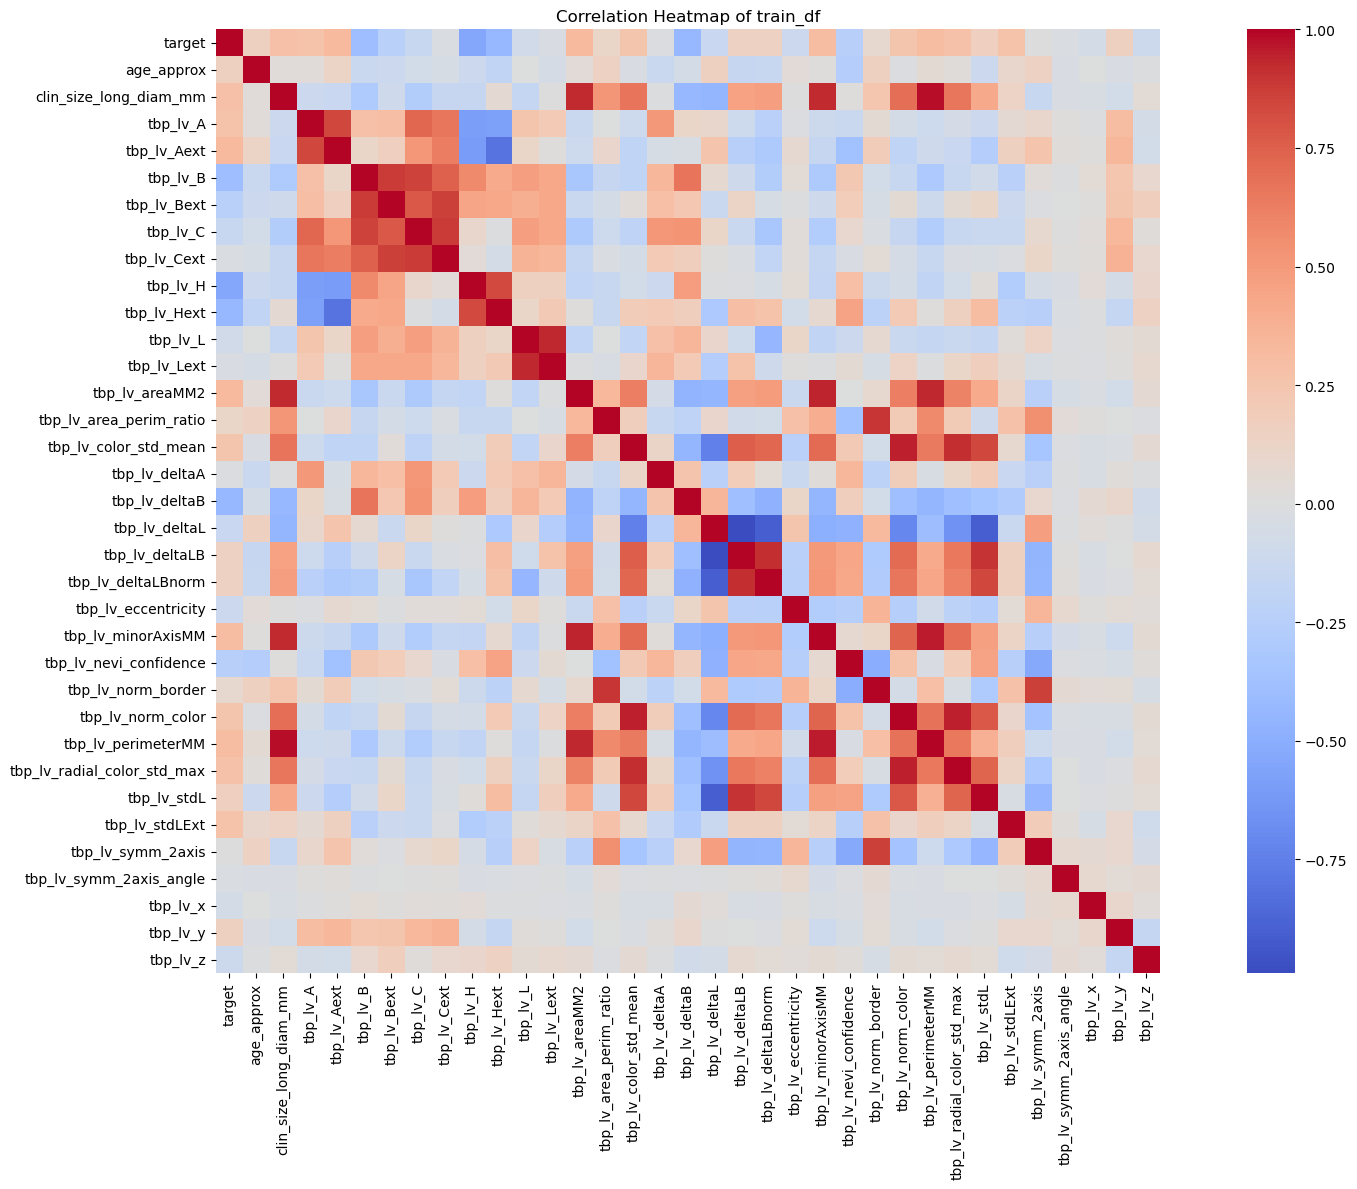

In [29]:
# Compute correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Title
plt.title('Correlation Heatmap of train_df')

# Show plot
plt.tight_layout()
plt.show()

# Models

## DummyClassifier

In [374]:
dum_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(strategy='most_frequent'))
    ]
)

## Decision Tree

In [375]:
dt_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED))
    ]
)

In [376]:
# Parameter grid for DecisionTree
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],  # None means no limit, tree grows until leaves are pure
    'classifier__min_samples_split': [2, 5, 10, 20],  # The minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4, 10],  # Minimum number of samples required at each leaf node
    'classifier__max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    #'classifier__criterion': ['gini', 'entropy'],  # Function to measure split quality
}

# Use roc_auc as the scoring function
grid_search = GridSearchCV(
    dt_pipe,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # This tells GridSearchCV to optimize for AUC
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print("Best ROC AUC score:", best_score)

Best ROC AUC score: 0.8847928018088144


In [377]:
predictions = best_model.predict_proba(X_test)[:, 1]

submission_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': predictions
})
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_M_DT_1.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Saved submission with 100 rows to submission_M_DT_1.csv


,isic_id,target
0,ISIC_0082829,1.000000
1,ISIC_0114227,0.142857
2,ISIC_0157465,0.187500
3,ISIC_0197356,0.200000
4,ISIC_0275647,0.000000
5,ISIC_0332355,1.000000
6,ISIC_0528190,0.900000
7,ISIC_0576478,0.029412
8,ISIC_0719839,1.000000
9,ISIC_0968965,0.666667


## Random Forest

In [28]:
rf_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced_subsample', random_state=RANDOM_SEED))
    ]
)

In [29]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']
}

# Use roc_auc as the scoring function
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print("Best ROC AUC score:", best_score)

Best ROC AUC score: 0.9496179217028426


In [30]:
predictions = best_model.predict_proba(X_test)[:, 1]

submission_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': predictions
})
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_M_RF_x10_woDNN_balsub.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Saved submission with 100 rows to submission_M_RF_x10_woDNN_balsub.csv


,isic_id,target
0,ISIC_0082829,0.678548
1,ISIC_0114227,0.026057
2,ISIC_0157465,0.000000
3,ISIC_0197356,0.000000
4,ISIC_0275647,0.009103
5,ISIC_0332355,0.721066
6,ISIC_0528190,0.584925
7,ISIC_0576478,0.023647
8,ISIC_0719839,0.336750
9,ISIC_0968965,0.152859


## XGBoost

In [106]:
xg_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=100531899))
    ]
)

In [107]:
xg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer())]),
                                                  ['age_approx',
                                                   'clin_size_long_diam_mm',
                                                   'tbp_lv_A', 'tbp_lv_Aext',
                                                   'tbp_lv_B', 'tbp_lv_Bext',
                                                   'tbp_lv_C', 'tbp_lv_Cext',
                                                   'tbp_lv_H', 'tbp_lv_Hext',
                                                   'tbp_lv_L', 'tbp_lv_Lext',
                                                   'tbp_lv_areaMM2',
                                                   'tbp_lv_area_perim_ratio',
                                                   'tbp_lv_color_std_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [108]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__reg_alpha': [0, 1, 3],
    'classifier__reg_lambda': [1, 3, 5],
    'classifier__subsample': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, 2, 5, 10, 20, 50, 100]
}

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search = GridSearchCV(
    xg_pipe,
    param_grid,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    error_score=0
)

# Fit on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print("Best ROC AUC score:", best_score)

Best ROC AUC score: 0.9466735969750217


In [109]:
predictions = best_model.predict_proba(X_test)[:, 1]

submission_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': predictions
})
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_M_XG_x10_finetuned.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Saved submission with 100 rows to submission_M_XG_x10_finetuned.csv


,isic_id,target
0,ISIC_0082829,0.603109
1,ISIC_0114227,0.001202
2,ISIC_0157465,0.000467
3,ISIC_0197356,0.000543
4,ISIC_0275647,0.001657
5,ISIC_0332355,0.311131
6,ISIC_0528190,0.517399
7,ISIC_0576478,0.001187
8,ISIC_0719839,0.453402
9,ISIC_0968965,0.014431
